# How to train your DragoNN tutorial 

## How to use this tutorial

This tutorial utilizes a Jupyter Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](./tutorial_images/play_button.png)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](./tutorial_images/play_all_button.png)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](./tutorial_images/inspecting_code.png)

## Tutorial Overview
In this tutorial, we will:

    1) Simulate regulatory DNA sequence classification task
    2) Train DragoNN models of varying complexity to solve the simulation
    3) Interpret trained DragoNN models
    4) Show how to train your DragoNN on your own, non-simulated data and use it to interpret data

This tutorial is implemented in python (see this [online python course](https://www.udacity.com/course/programming-foundations-with-python--ud036) for an introduction).

We start by loading dragonn's tutorial utilities. Let's review properties of regulatory sequence while the utilities are loading

In [7]:
from dragonn.tutorial_utils import *
%matplotlib inline

![sequence properties 1](./tutorial_images/sequence_properties_1.jpg)
![sequence properties 2](./tutorial_images/sequence_properties_2.jpg)
![sequence properties 3](./tutorial_images/sequence_properties_3.jpg)
![sequence properties 4](./tutorial_images/sequence_properties_4.jpg)

In this tutorial, we will simulate heterodimer motif grammar detection task. Specifically, we will simulate a "positive" class of sequences with a SIX5-ZNF143 grammar with relatively fixed spacing between the motifs and a negative class of sequences containing both motifs positioned independently:
![heterodimer simulation](./tutorial_images/heterodimer_simulation.jpg)
Here is an overview of the sequence simulation functions in the dragonn tutorial:
![sequence](./tutorial_images/sequence_simulations.png)

Let's run the print_available_simulations function and see it in action.

In [8]:
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection


## Getting simulation data

To get simulation data we:
    
    1) Define the simulation parameters
        - obtain description of simulation parameters using the print_simulation_info function
    2) Call the get_simulation_data function, which takes as input the simulation name and the simulation
    parameters, and outputs the simulation data.

We simulate the SIX5-ZNF143 heterodimer motif grammar using the "simulate_heterodimer_grammar" simulation function. To get a description of the simulation parameters we use the print_simulation_info function, which takes as input the simulation function name, and outputs documentation for the simulation including the simulation parameters:

In [9]:
print_simulation_info("simulate_heterodimer_grammar")


    Simulates two classes of sequences with motif1 and motif2:
        - Positive class sequences with motif1 and motif2 positioned
          min_spacing and max_spacing
        - Negative class sequences with independent motif1 and motif2 positioned
        anywhere in the sequence, not as a heterodimer grammar

    Parameters
    ----------
    seq_length : int, length of sequence
    GC_fraction : float, GC fraction in background sequence
    num_pos : int, number of positive class sequences
    num_neg : int, number of negatice class sequences
    motif1 : str, encode motif name
    motif2 : str, encode motif name
    min_spacing : int, minimum inter motif spacing
    max_spacing : int, maximum inter motif spacing

    Returns
    -------
    sequence_arr : 1darray
        Array with sequence strings.
    y : 1darray
        Array with positive/negative class labels.
    


Next, we define parameters for a heterodimer grammar simulation of 500bp long sequence, with 0.4 GC fraction, 10000 positive and negative sequences, with SIx5 and ZNF143 motifs spaced 2-10 bp apart in the positive sequences:

In [10]:
heterodimer_grammar_simulation_parameters = {
    "seq_length": 500,
    "GC_fraction": 0.4,
    "num_pos": 10000,
    "num_neg": 10000,
    "motif1": "SIX5_known1",
    "motif2": "ZNF143_known1",
    "min_spacing": 2,
    "max_spacing": 10}

We get the simulation data by calling the get_simulation_data function with the simulation name and the simulation parameters as inputs.

In [11]:
simulation_data = get_simulation_data("simulate_heterodimer_grammar", heterodimer_grammar_simulation_parameters)

simulation_data provides training, validation, and test sets of input sequences X and sequence labels y. The inputs X are matrices with a one-hot-encoding of the sequences:
![one hot encoding](./tutorial_images/one_hot_encoding.png)
Here are the first 10bp of a sequence in our training data:

In [12]:
simulation_data.X_train[0, :, :, :10]

array([[[0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0]]], dtype=int8)

This matrix represent the 10bp sequence TTGGTAGATA.

Next, we will provide a brief overview of DragoNNs and proceed to train a DragoNN to classify the sequences we simulated:
![classificatioin task](./tutorial_images/classification_task.jpg)

# DragoNN Models

A locally connected linear unit in a DragoNN model can represent a PSSM (part a). A sequence PSSM score is obtained by multiplying the PSSM across the sequence, thersholding the PSSM scores, and taking the max (part b). A PSSM score can also be computed by a DragoNN model with tiled locally connected linear units, amounting to a convolutional layer with a single convolutional filter representing the PSSM, followed by ReLU thersholding and maxpooling (part c).
![dragonn vs pssm](./tutorial_images/dragonn_and_pssm.jpg)
By utilizing multiple convolutional layers with multiple convolutional filters, DragoNN models can represent a wide range of sequence features in a compositional fashion:
![dragonn model figure](./tutorial_images/dragonn_model_figure.jpg)

# Getting a DragoNN model

The main DragoNN model class is SequenceDNN, which provides a simple interface to a range of models and methods to train, test, and interpret DragoNNs. SequenceDNN uses [keras](http://keras.io/), a deep learning library for [Theano](https://github.com/Theano/Theano) and [TensorFlow](https://github.com/tensorflow/tensorflow), which are popular software packages for deep learning.

To get a DragoNN model we:
    
    1) Define the DragoNN architecture parameters
        - obtain description of architecture parameters using the inspect_SequenceDNN() function
    2) Call the get_SequenceDNN function, which takes as input the DragoNN architecture parameters, and outputs a 
    randomly initialized DragoNN model.

To get a description of the architecture parameters we use the inspect_SequenceDNN function, which outputs documentation for the model class including the architecture parameters:

In [13]:
inspect_SequenceDNN()

Sequence DNN models.

Parameters
----------
seq_length : int, optional
    length of input sequence.
keras_model : instance of keras.models.Sequential, optional
    seq_length or keras_model must be specified.
num_tasks : int, optional
    number of tasks. Default: 1.
num_filters : list[int] | tuple[int]
    number of convolutional filters in each layer. Default: (15,).
conv_width : list[int] | tuple[int]
    width of each layer's convolutional filters. Default: (15,).
pool_width : int
    width of max pooling after the last layer. Default: 35.
L1 : float
    strength of L1 penalty.
dropout : float
    dropout probability in every convolutional layer. Default: 0.
verbose: int
    Verbosity level during training. Valida values: 0, 1, 2.

Returns
-------
Compiled DNN model.

Available methods:

deeplift
get_sequence_filters
in_silico_mutagenesis
plot_architecture
plot_deeplift
plot_in_silico_mutagenesis
predict
save
score
test
train


"Available methods" display what can be done with a SequenceDNN model. These include common operations such as training and testing the model, and more complex operations such as extracting insight from trained models. We define a simple DragoNN model with one convolutional layer with one convolutional filter, followed by maxpooling of width 35. 

In [14]:
one_filter_dragonn_parameters = {
    'seq_length': 500,
    'num_filters': [1],
    'conv_width': [45],
    'pool_width': 45}

we get a radnomly initialized DragoNN model by calling the get_SequenceDNN function with one_filter_dragonn_parameters as the input

In [15]:
one_filter_dragonn = get_SequenceDNN(one_filter_dragonn_parameters)

## Training a DragoNN model

Next, we train the one_filter_dragonn by calling train_SequenceDNN with one_filter_dragonn and simulation_data as the inputs. In each epoch, the one_filter_dragonn will perform a complete pass over the training data, and update its parameters to minimize the loss, which quantifies the error in the model predictions. After each epoch, the code prints performance metrics for the one_filter_dragonn on the validation data. Training stops once the loss on the validation stops improving for multiple consecutive epochs. The performance metrics include balanced accuracy, area under the receiver-operating curve ([auROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)), are under the precision-recall curve ([auPRC](https://en.wikipedia.org/wiki/Precision_and_recall)), area under the precision-recall-gain curve ([auPRG](https://papers.nips.cc/paper/5867-precision-recall-gain-curves-pr-analysis-done-right.pdf)), and recall for multiple false discovery rates  (Recall at [FDR](https://en.wikipedia.org/wiki/False_discovery_rate)).

In [16]:
train_SequenceDNN(one_filter_dragonn, simulation_data)

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.6944	Balanced Accuracy: 50.37%	 auROC: 0.503	 auPRC: 0.496	 auPRG: 0.003
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6338	 Num Negatives: 6462
Valid Loss: 0.6948	Balanced Accuracy: 48.86%	 auROC: 0.484	 auPRC: 0.505	 auPRG: -0.033
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1645	 Num Negatives: 1555 *
Epoch 2:
Train Loss: 0.6937	Balanced Accuracy: 50.04%	 auROC: 0.502	 auPRC: 0.499	 auPRG: 0.003
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6338	 Num Negatives: 6462
Valid Loss: 0.6935	Balanced Accuracy: 49.10%	 auROC: 0.489	 auPRC: 0.505	 auPRG: -0.020
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1645	 Num Negatives: 1555 *
Epoch 3:
Train Loss: 0.6935	Balanced Accuracy: 50.01%	 auROC: 0.502	 auPRC: 0.494	 auPRG: 0.006
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6338	 Num Negatives: 6462
Valid Loss: 0.6932	Balanced Accuracy: 49.29%	 auROC: 0.496	 auPR

We can see that the validation loss is not decreasing and the auROC metric is not decreasing, which indicates this model is not learning. A simple plot of the learning curve, showing the loss function on the training and validation data over the course of training, demonstrates this visually:

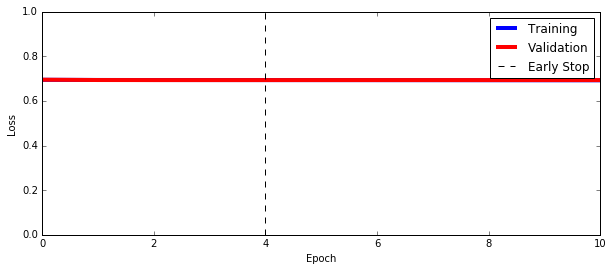

In [17]:
SequenceDNN_learning_curve(one_filter_dragonn)

# A multi-filter DragoNN model 
Next, we modify the model to have 15 convolutional filters instead of just one filter. Will the model learn now?

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.7036	Balanced Accuracy: 52.37%	 auROC: 0.529	 auPRC: 0.520	 auPRG: 0.057
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6338	 Num Negatives: 6462
Valid Loss: 0.7071	Balanced Accuracy: 50.28%	 auROC: 0.506	 auPRC: 0.527	 auPRG: 0.004
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 1645	 Num Negatives: 1555 *
Epoch 2:
Train Loss: 0.6897	Balanced Accuracy: 54.68%	 auROC: 0.564	 auPRC: 0.551	 auPRG: 0.121
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6338	 Num Negatives: 6462
Valid Loss: 0.7028	Balanced Accuracy: 50.96%	 auROC: 0.514	 auPRC: 0.532	 auPRG: 0.018
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1645	 Num Negatives: 1555 *
Epoch 3:
Train Loss: 0.6877	Balanced Accuracy: 54.60%	 auROC: 0.596	 auPRC: 0.580	 auPRG: 0.183
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6338	 Num Negatives: 6462
Valid Loss: 0.7162	Balanced Accuracy: 50.75%	 auROC: 0.520	 auPRC:

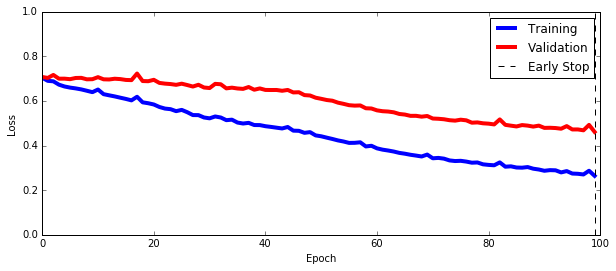

In [18]:
multi_filter_dragonn_parameters = {
    'seq_length': 500,
    'num_filters': [15], ## notice the change from 1 filter to 15 filters
    'conv_width': [45],
    'pool_width': 45,
    'dropout': 0.1}
multi_filter_dragonn = get_SequenceDNN(multi_filter_dragonn_parameters)
train_SequenceDNN(multi_filter_dragonn, simulation_data)
SequenceDNN_learning_curve(multi_filter_dragonn)

## Interpreting a DragoNN model using filter visualization
We can see that the model has learned effectively as indicated by a high auROC and decreasing loss over the course of training. Let's see what if trained convolutional filters look like the simulated motifs.

Plotting simulation motifs...


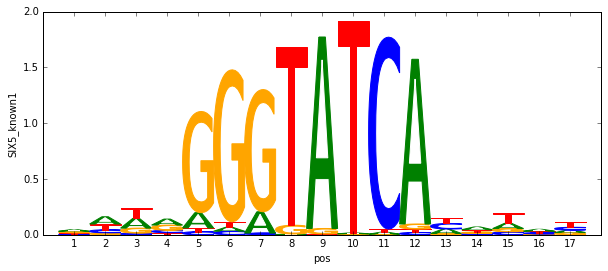

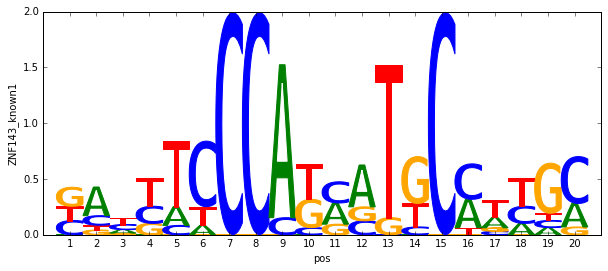

Visualizing convolutional sequence filters in SequenceDNN...


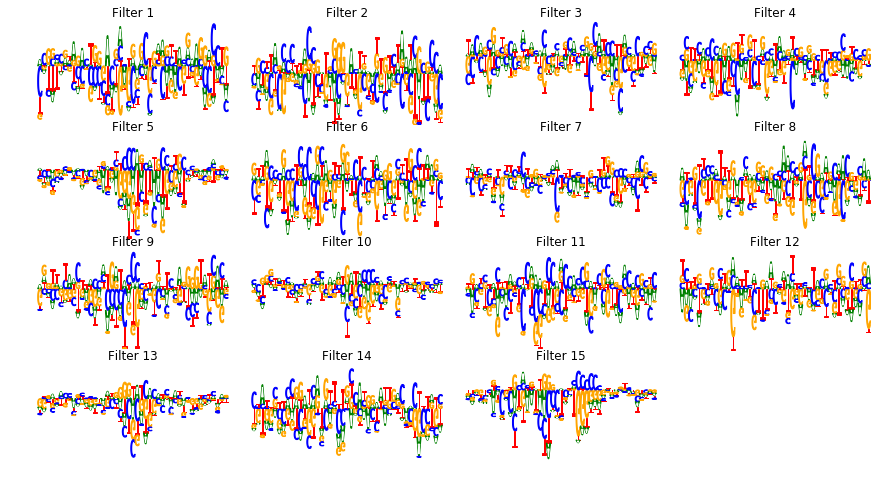

In [19]:
interpret_SequenceDNN_filters(multi_filter_dragonn, simulation_data)

We can see that filters 6 and 12 encode similar heterodimer patterns with different spacings. These include a string of Gs on the left to detect SIX5 and a string of Cs on the right to detect ZNF143. Filter 15 seems to represent SIX5 only. Other filters also show spatial biases, like filter 9, but their importance is not clear. Filter visualization represents an interpretation that is independent of context - we are trying to make sense of trained sequence filters in general and not in the context of specific sequences. Next we explore methods to interpret DragoNN models in the context of specific sequences. 

# Interpreting data with a DragoNN model

Using in-silico mutagenesis (ISM) and [DeepLIFT](https://arxiv.org/pdf/1605.01713v2.pdf), we can obtain scores for specific sequence indicating the importance of each position in the sequence. To assess these methods we compare ISM and DeepLIFT scores to motif scores for each simulated motif at each position in the sequence. These motif scores represent the "ground truth" importance of each position because they are based on the motifs used to simulate the data. We plot provide comaprisons for a positive class sequence on the left and a negative class sequence on the right.

/usr/local/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


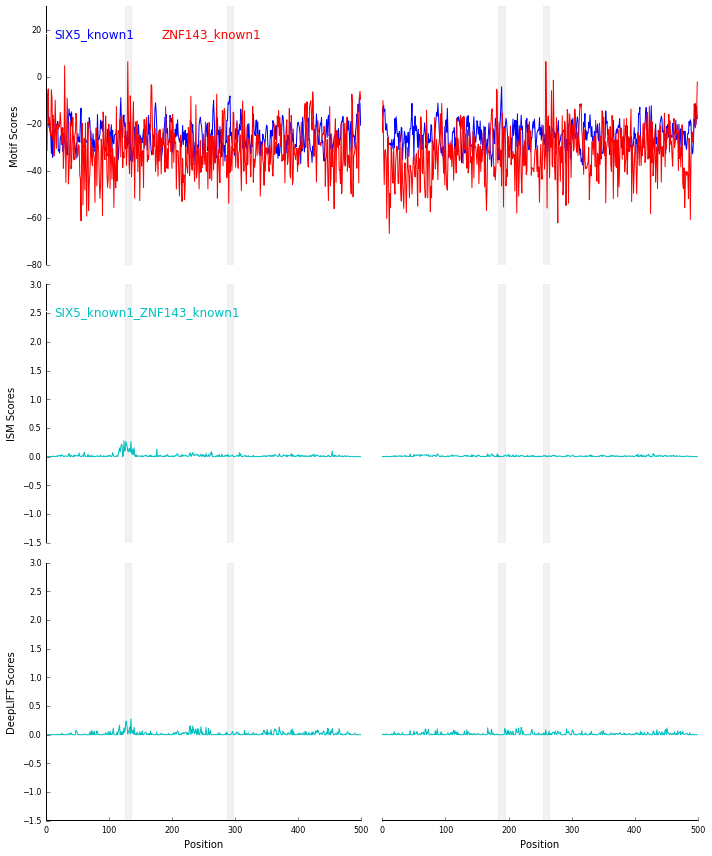

In [20]:
interpret_data_with_SequenceDNN(multi_filter_dragonn, simulation_data)

We can see that DeepLIFT scores correctly highlight the hetordimer motif grammar sequence in the positive class (left) while ISM fails to identify the heterodimer motif grammar. In the negative class sequence (right), where the motifs not part of a grammar, both methods correctly indicate there are no positive class features. 

# A multi-layer DragoNN model
Next, we extend modify multi_filter_dragon to have 3 convolutional layers, with convolutional filter of 15 in each layer, to learn the heterodimer grammar compositionally across multiple layers.

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.6933	Balanced Accuracy: 51.50%	 auROC: 0.525	 auPRC: 0.516	 auPRG: 0.047
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 6338	 Num Negatives: 6462
Valid Loss: 0.6940	Balanced Accuracy: 51.03%	 auROC: 0.505	 auPRC: 0.519	 auPRG: 0.014
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1645	 Num Negatives: 1555 *
Epoch 2:
Train Loss: 0.6908	Balanced Accuracy: 51.87%	 auROC: 0.552	 auPRC: 0.542	 auPRG: 0.098
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 6338	 Num Negatives: 6462
Valid Loss: 0.6969	Balanced Accuracy: 50.11%	 auROC: 0.513	 auPRC: 0.524	 auPRG: 0.026
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1645	 Num Negatives: 1555
Epoch 3:
Train Loss: 0.6886	Balanced Accuracy: 53.33%	 auROC: 0.576	 auPRC: 0.563	 auPRG: 0.146
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 6338	 Num Negatives: 6462
Valid Loss: 0.6953	Balanced Accuracy: 51.27%	 auROC: 0.517	 auPRC: 0

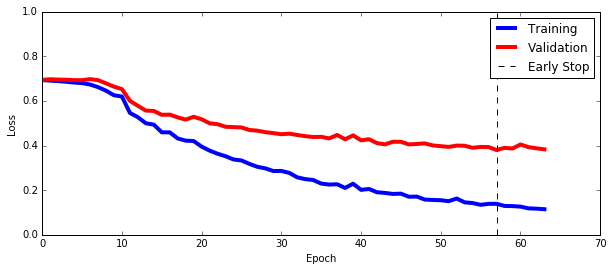

In [21]:
multi_layer_dragonn_parameters = {
    'seq_length': 500,
    'num_filters': [15, 15, 15], ## notice the change to multiple filter values, one for each layer
    'conv_width': [25, 25, 25], ## convolutional filter width has been modified to 25 from 45
    'pool_width': 45,
    'dropout': 0.1}
multi_layer_dragonn = get_SequenceDNN(multi_layer_dragonn_parameters)
train_SequenceDNN(multi_layer_dragonn, simulation_data)
SequenceDNN_learning_curve(multi_layer_dragonn)

The multi-layered DragoNN model achieves a higher auROC and a lower training and validation loss than the multi-filter DragoNN model. Try the same model without dropout regularization: how important is dropout?

Let's see what the model learns in its sequence filters.

Plotting simulation motifs...


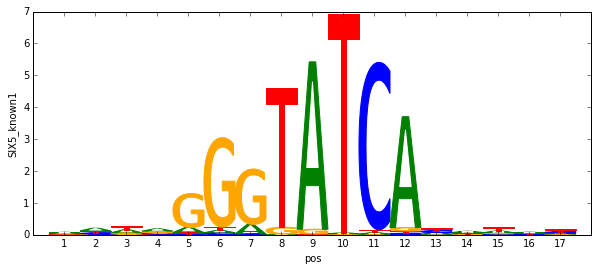

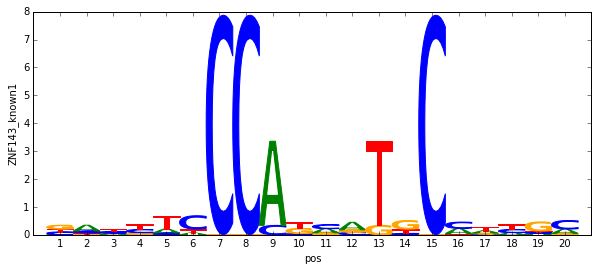

Visualizing convolutional sequence filters in SequenceDNN...


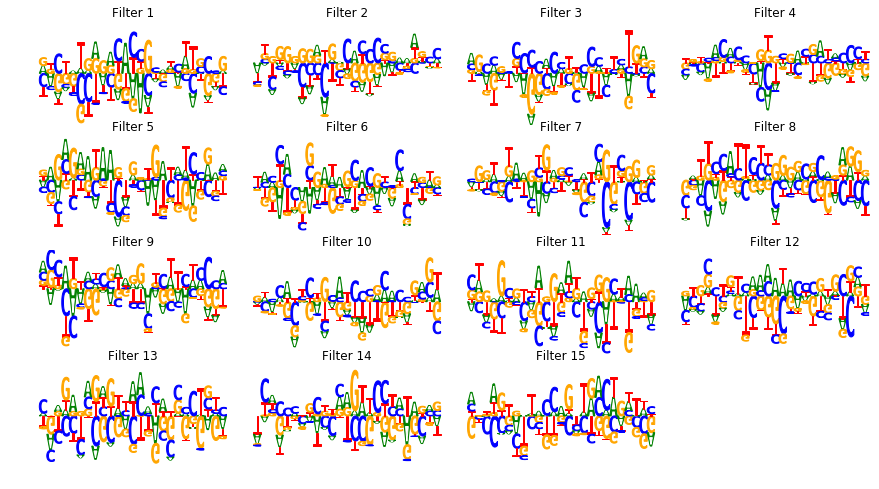

In [22]:
interpret_SequenceDNN_filters(multi_layer_dragonn, simulation_data)

The sequence filters here are not amenable to interpretation based on visualization alone. In multi-layered models, sequence features are learned compositionally across the layers. As a result, sequence filters in the first layer focus more on simple features that can be combined in higher layers to learn motif features more efficiently, and their interpretation becomes less clear based on simple visualizations. Let's see where ISM and DeepLIFT get us with this model.

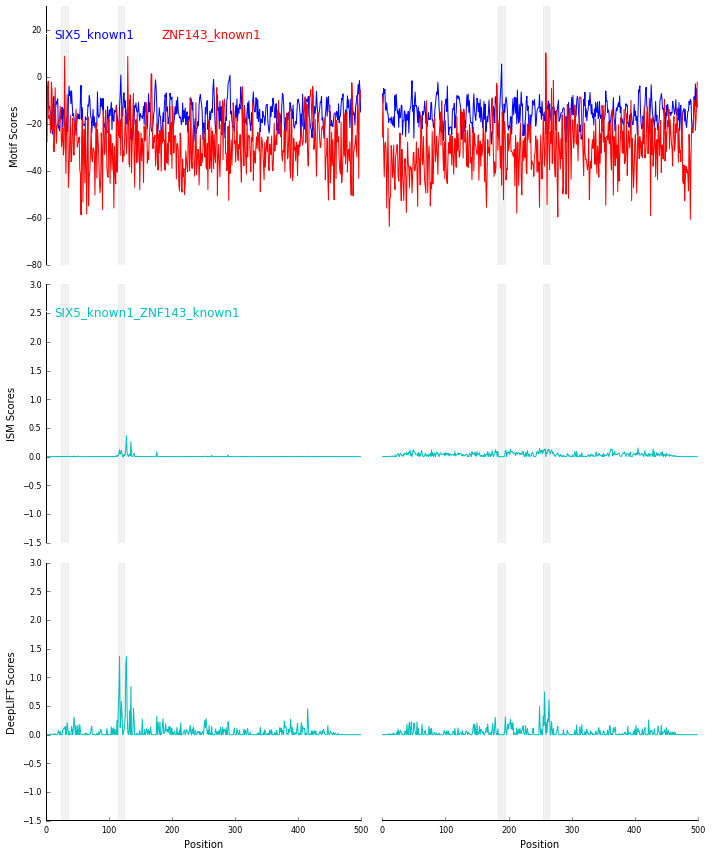

In [23]:
interpret_data_with_SequenceDNN(multi_layer_dragonn, simulation_data)

DeepLIFT scores for this model remain highly interpretable. The SIX5-ZNF143 grammar is clearly highlighted in the positive class sequence. DeepLIFT scores also peak around position ~300, almost to the level of the DeepLIFT scores at the SIX5 location, even though there are no substantial motif scores there. Consider this question: what might be some ways to assess if the scores at position ~300 represent a real feature or artifacts?

# Using DragoNN on your own non-simulated data

The dragonn package provides a command-line interface to train and test DragoNN models, and use them to predict and interpret new data. We start by training a dragonn model on positive and negative sequence:

In [24]:
!dragonn train --pos-sequences example_pos_sequences.fa --neg-sequences example_neg_sequences.fa --prefix training_example

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, CuDNN not available)
/usr/local/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
loading sequence data...
initializing model...
starting model training...
Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.6853	Balanced Accuracy: 54.64%	 auROC: 0.573	 auPRC: 0.562	 auPRG: 0.126
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1976	 Num Negatives: 2024
Valid Loss: 0.6919	Balanced Accuracy: 53.13%	 auROC: 0.541	 auPRC: 0.549	 auPRG: 0.072
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 524	 Num Negatives: 476 *
Epoch 2:
Train Loss: 0.6710	Balanced Accuracy: 59.41%	 auROC: 0.644	 auPRC: 0.631	 auPRG: 0.277
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|3.2%	 Num Positives: 1976	 Num Negatives: 2024
V

Based on the provided prefix, this command stores a model file, training_example.model.json, with the model architecture and a weights file, training_example.weights.hd5, with the parameters of the trained model. We test the model by running:

In [25]:
!dragonn test --pos-sequences example_pos_sequences.fa --neg-sequences example_neg_sequences.fa \
--arch-file training_example.arch.json --weights-file training_example.weights.h5

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, CuDNN not available)
/usr/local/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
loading sequence data...
loading model...
testing model...
Loss: 0.3077	Balanced Accuracy: 88.80%	 auROC: 0.953	 auPRC: 0.953	 auPRG: 0.930
	Recall at 5%|10%|20% FDR: 79.2%|90.0%|95.4%	 Num Positives: 2500	 Num Negatives: 2500


This command prints the model's test performance metrics on the provided data. Model predictions on sequence data can be obtained by running:

In [26]:
!dragonn predict --sequences example_pos_sequences.fa --arch-file training_example.arch.json \
--weights-file training_example.weights.h5 --output-file example_predictions.txt

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, CuDNN not available)
/usr/local/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
loading sequence data...
loading model...
getting predictions...
saving predictions to output file...
Done!


This command stores the model predictions for sequences in example_pos_sequences.fa in the output file example_predictions.txt. We can interpret sequence data with a dragonn model by running:

In [27]:
!dragonn interpret --sequences example_pos_sequences.fa --arch-file training_example.arch.json \
--weights-file training_example.weights.h5 --prefix example_interpretation

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, CuDNN not available)
/usr/local/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
loading sequence data...
loading model...
getting predictions...
getting deeplift scores...
extracting important sequences and writing to file...
Done!


This will write the most important subsequence in each input sequence along with its location in the input sequence in the file example_interpretation.task_0.important_sequences.txt. Note: by default, only examples with predicted positive class probability >0.5 are interpreted. Examples below this threshold yield important subsequence of Ns with location -1. Let's look the first few lines of this file:

In [28]:
!head example_interpretation.task_0.important_sequences.txt

> sequence_0
409: AAAGTGCTGGCCTGAGGAGG
> sequence_1
375: CACCTGGTGGCCCCGAAGGT
> sequence_2
400: GCCAGCAGGCGGCGTGCCAC
> sequence_3
424: TGTCTCCCACCCATGAGAGA
> sequence_4
422: GAGGAAGTGCCTTCCTCAGG


## Extras for HW

The tutorial example here touches on general principles of DragoNN model development and interpretation. To gain a deeper insight into the difference between DeepLIFT and ISM for model interpretation, consider the following exercise:

Train, test, and run sequence-centric interpretation for the one layered CNN model used here for the following
simulations:
    1. single motif detection simulation of TAL1 in 1000bp sequence with 40% GC content
    (run print_simulation_info("simulate_single_motif_detection") to see the exact simulation parameters)
    2. motif density localization simulation of 2-4 TAL1 motif instances in the central of 150bp of a total 1000bp
    sequence with 40% GC
    content
    (run print_simulation_info("simulate_motif_density_localization") to see the exact simulation parameters)

Key questions:

    1) What could explain the difference in ISM's sensitivity to the TAL1 motif sequence between the simulations?
    2) What does that tell us about the the scope of ISM for feature discovery? Under what conditions is it likely
    to show sensitivity to sequence features?
    
Starter code is provided below to get the data for each simulation and new DragoNN model.


In [29]:
single_motif_detection_simulation_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

density_localization_simulation_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

single_motif_detection_simulation_data = get_simulation_data(
    "simulate_single_motif_detection", single_motif_detection_simulation_parameters)

density_localization_simulation_data = get_simulation_data(
    "simulate_motif_density_localization", density_localization_simulation_parameters)

In [30]:
new_dragonn_model = get_SequenceDNN(multi_layer_dragonn_parameters)